# Курсовой проект для курса "Python для Data Science"

## Задание для курсового проекта


Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Соревнование заканчивается 22.08.20
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


### Загурзка необходимых библиотек

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from scipy import stats

### Функция уменьшения памяти занимаемой данными

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных

In [10]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [11]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [12]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [13]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [14]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Проверка данных

In [15]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [16]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360350,20.423913,1.136859,41.814371,52.645757,66.036608,6.410652e+02
LifeSquare,11846.0,36.851792,71.120183,0.333490,22.896130,32.822810,45.144624,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218671e-01


#### Корректировка количества комнат

In [17]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
13398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [18]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
12406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
12524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [19]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

#### Корректировка площади комнат

In [20]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
13217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
13909,1397,76,3.0,221.138768,118.055342,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


Text(0.5, 1.0, 'Square distribution')

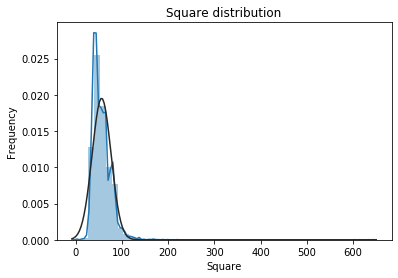

In [21]:
sns.distplot(all_data['Square'], fit=norm)


plt.ylabel('Frequency')
plt.title('Square distribution')

In [22]:
def df_fix_square_first(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [23]:
def df_fix_square(df):
    sigma = norm.fit(df['Square'])[1]
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    
    return df

In [24]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [25]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)

In [26]:
all_data = df_fix_room(all_data)
all_data = df_fix_square_first(all_data)
all_data = df_fix_square(all_data)

Text(0.5, 1.0, 'Square distribution')

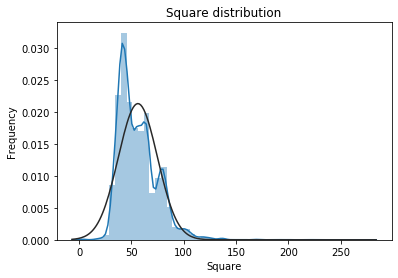

In [27]:
sns.distplot(all_data['Square'], fit=norm)


plt.ylabel('Frequency')
plt.title('Square distribution')

Text(0.5, 1.0, 'LifeSquare distribution')

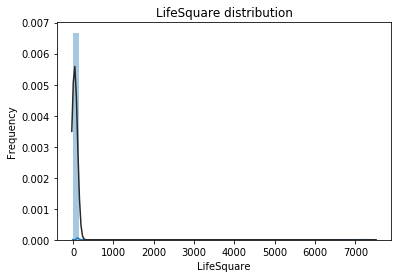

In [28]:
sns.distplot(all_data['LifeSquare'], fit=norm)


plt.ylabel('Frequency')
plt.title('LifeSquare distribution')

In [29]:
 all_data.loc[all_data['LifeSquare'] > 250, 'LifeSquare']

590       263.542020
4328     7480.592129
4690      410.639749
6977      638.163193
8437      461.463614
10410     303.071094
Name: LifeSquare, dtype: float64

In [30]:
def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df

#### Корректировка года постройки дома

In [31]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_square_per_room_in_dr,mean_square_rooms_dr
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,B,30,6141,10,262.0,3,6,B,37.265070,37.265070
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,B,25,4756,16,2857.0,5,8,B,22.395918,44.791836


In [32]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [33]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

### Целевая переменная

#### Нормальное распределение целевой переменной

Text(0.5, 1.0, 'Price distribution')

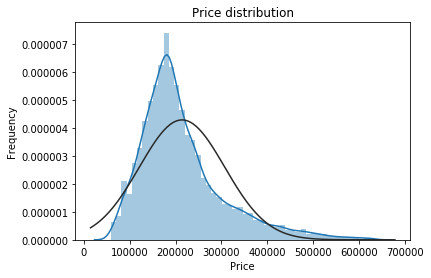

In [34]:
sns.distplot(train['Price'], fit=norm)


plt.ylabel('Frequency')
plt.title('Price distribution')

#### Устранение пропущенных данных

In [35]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [36]:
all_data.info(memory_usage='deep')
df_fix_house_year_manual(all_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
14996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
14997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
14998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [37]:
def df_del_missing(df):
    df.drop(['Healthcare_1'], axis=1, inplace=True)
    return df

### Обработка категорий

In [38]:
def df_category(df):
    df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
    df.rename(columns={'A': 'Ecology_2_A', 'B': 'Ecology_2_B'}, inplace=True)
    df.drop(['Ecology_2'], axis=1, inplace=True)
    df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)
    df.rename(columns={'A': 'Ecology_3_A', 'B': 'Ecology_3_B'}, inplace=True)
    df.drop(['Ecology_3'], axis=1, inplace=True)
    df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
    df.rename(columns={'A': 'Shops_2_A', 'B': 'Shops_2_B'}, inplace=True)
    df.drop(['Shops_2'], axis=1, inplace=True)
    return df

In [39]:
train = df_category(train)

#### Корреляция данных

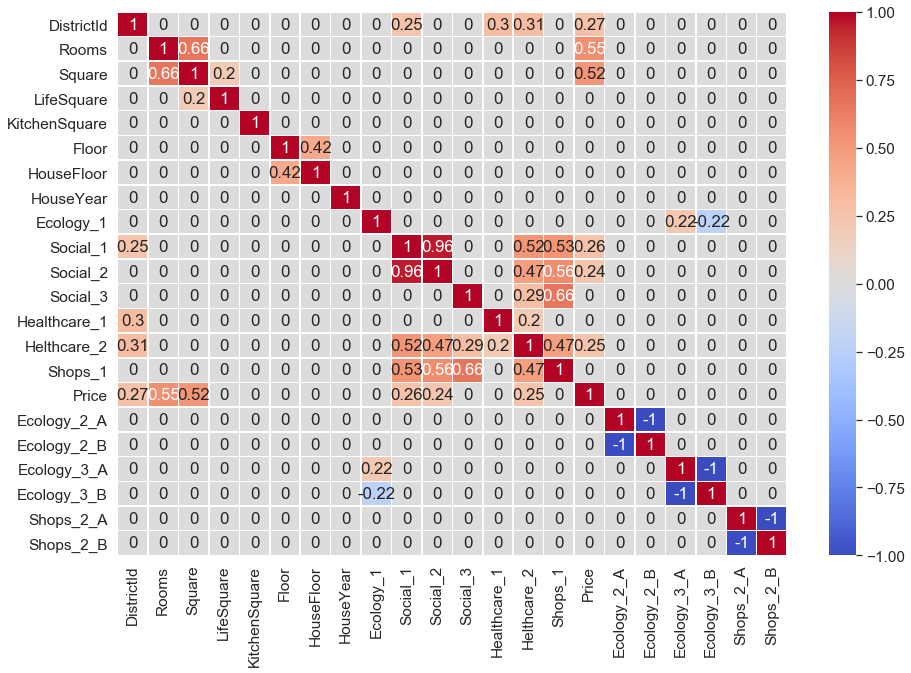

In [40]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train.loc[:, train.columns != 'Id'].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

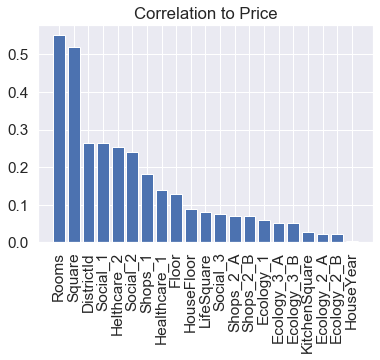

In [41]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [42]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,NaN,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,229.0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,150226.531644,0,1,0,1,0,1


#### Создание фичи - разбиение на кластеры по годам

In [43]:
scaler = MinMaxScaler()

In [44]:
train_cluster = train.copy()

In [45]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [46]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear']]), columns=['HouseYear'])

In [47]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [48]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
   train_cluster_scaled)

Text(0.5, 1.0, 'Train')

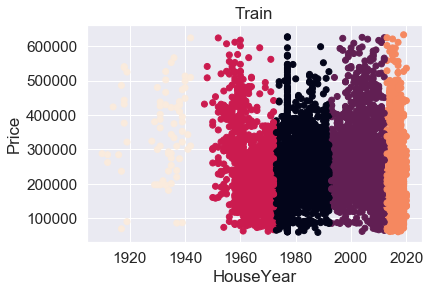

In [49]:
plt.scatter(train_cluster['HouseYear'],
           train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [50]:
def add_cluster_year(df):
    scaler = MinMaxScaler()
    agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

#### Добавление фичи - Ср. цена в завичимости от числа комнат и ср.цена в зависимости от района и числа комнат

In [51]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

#### Добавление фичи - размер района 

In [52]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    return df

## Модель

### Функция подоготовки данных

In [53]:
def data_prepare(df, df_train=train):
    df = df_fix_square_first(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    df = reduce_mem_usage(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    
    print("R2:\t" + str(round(r2(valid, model_pred), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(valid, model_pred)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(valid, model_pred), 3))
         )
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=model_pred, y=valid)
    plt.plot([0, 633233], [0, 633233], linestyle='--', color='black') 
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.show()

### Загрузка пакетов

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV , KFold

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.model_selection import train_test_split

###  Подготовка данных

In [55]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [56]:
train = data_prepare(train, train)

Memory usage of dataframe is 1.66 MB
Memory usage after optimization is: 0.58 MB
Decreased by 64.9%


Text(0.5, 1.0, 'Price distribution')

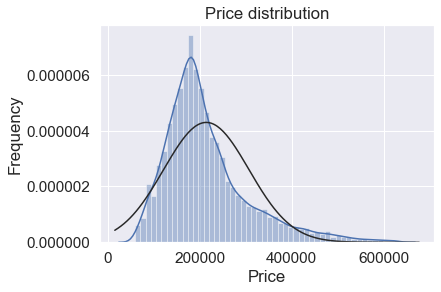

In [57]:
sns.distplot(train['Price'], fit=norm)


plt.ylabel('Frequency')
plt.title('Price distribution')

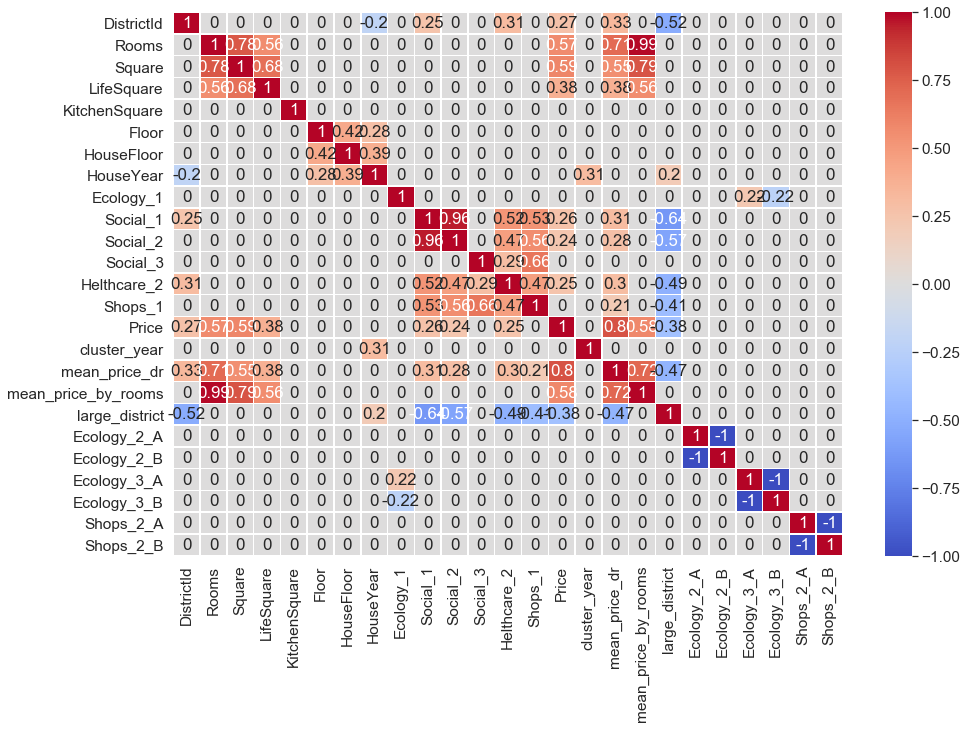

In [58]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train.loc[:, train.columns != 'Id'].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

In [59]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'cluster_year',
       'mean_price_dr', 'mean_price_by_rooms', 'large_district', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')


In [60]:
features = list(train.loc[:, (train.columns != 'Id') & (train.columns != 'Price')])

target = 'Price'

In [61]:
train[features].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.96875,29.437500,6.0,7,9.0,1969,0.089050,33,...,2,213160.078125,215256.312500,22,0.0,1.0,0.0,1.0,0.0,1.0
1,41,3.0,65.68750,40.062500,8.0,7,9.0,1978,0.000070,46,...,0,303643.562500,289337.968750,87,0.0,1.0,0.0,1.0,0.0,1.0
2,53,2.0,44.93750,29.203125,0.0,8,12.0,1968,0.049652,34,...,2,259938.734375,215256.312500,174,0.0,1.0,0.0,1.0,0.0,1.0
3,58,2.0,53.34375,52.718750,9.0,8,17.0,1977,0.437988,23,...,0,172368.875000,215256.312500,179,0.0,1.0,0.0,1.0,0.0,1.0
4,99,1.0,39.65625,23.781250,7.0,11,12.0,1976,0.012337,35,...,0,155748.421875,159850.796875,97,0.0,1.0,0.0,1.0,0.0,1.0


### Стандартизация признаков

In [62]:
feature_names_for_stand = train[features].columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'cluster_year',
 'mean_price_dr',
 'mean_price_by_rooms',
 'large_district',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [63]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train[feature_names_for_stand])
train[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           7000 non-null   float32
 1   Rooms                7000 non-null   float32
 2   Square               7000 non-null   float32
 3   LifeSquare           7000 non-null   float32
 4   KitchenSquare        7000 non-null   float32
 5   Floor                7000 non-null   float32
 6   HouseFloor           7000 non-null   float32
 7   HouseYear            7000 non-null   float32
 8   Ecology_1            7000 non-null   float32
 9   Social_1             7000 non-null   float32
 10  Social_2             7000 non-null   float32
 11  Social_3             7000 non-null   float32
 12  Helthcare_2          7000 non-null   float32
 13  Shops_1              7000 non-null   float32
 14  cluster_year         7000 non-null   float32
 15  mean_price_dr        7000 non-null 

In [66]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 6252 to 4705
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           3000 non-null   float32
 1   Rooms                3000 non-null   float32
 2   Square               3000 non-null   float32
 3   LifeSquare           3000 non-null   float32
 4   KitchenSquare        3000 non-null   float32
 5   Floor                3000 non-null   float32
 6   HouseFloor           3000 non-null   float32
 7   HouseYear            3000 non-null   float32
 8   Ecology_1            3000 non-null   float32
 9   Social_1             3000 non-null   float32
 10  Social_2             3000 non-null   float32
 11  Social_3             3000 non-null   float32
 12  Helthcare_2          3000 non-null   float32
 13  Shops_1              3000 non-null   float32
 14  cluster_year         3000 non-null   float32
 15  mean_price_dr        3000 non-null 

In [67]:
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9069,-0.628669,-1.093677,-0.765441,-0.849224,0.060460,1.044346,0.647998,1.636743,-0.361709,-1.065895,...,1.656431,-1.517339,-1.015704,1.199696,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
2603,-0.628669,1.367342,2.334081,4.164201,0.200518,-0.672921,-1.418229,-0.427246,-0.880364,-1.294053,...,-0.933766,-0.579538,1.405643,1.199696,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
7738,0.839712,-1.093677,-0.870312,-1.061631,0.060460,-0.863728,0.647998,0.061594,-0.154529,1.044563,...,-0.933766,-0.550553,-1.015704,-0.800458,-0.09897,0.09897,-0.16816,0.16816,3.334848,-3.334848
1579,-0.055083,1.367342,2.130997,3.916223,-0.184643,1.235154,-1.713404,1.745374,-0.652991,1.215681,...,1.656431,2.466616,1.405643,-0.566239,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864
5058,0.610278,1.367342,1.232103,0.556324,0.130489,1.425961,0.647998,-0.047037,1.505987,-0.495501,...,-0.933766,0.485968,1.405643,-0.752127,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864


In [68]:
y_train.head()

9069     88504.382812
2603    207007.953125
7738    182126.281250
1579    524365.562500
5058    322048.437500
Name: Price, dtype: float32

### VotingRegressor

In [69]:
model1 = GradientBoostingRegressor(n_estimators=442, max_depth=5, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)

model2 = RandomForestRegressor(n_estimators=1442, max_depth=18, random_state=42, max_features=7)

model3 = LGBMRegressor()

model = VotingRegressor([('model1', model1), ('model2', model2), ('model3', model3)])

model.fit(X_train, y_train)

VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                

R2:	0.766
RMSE:	44852.205
MSE:	2011720252.68


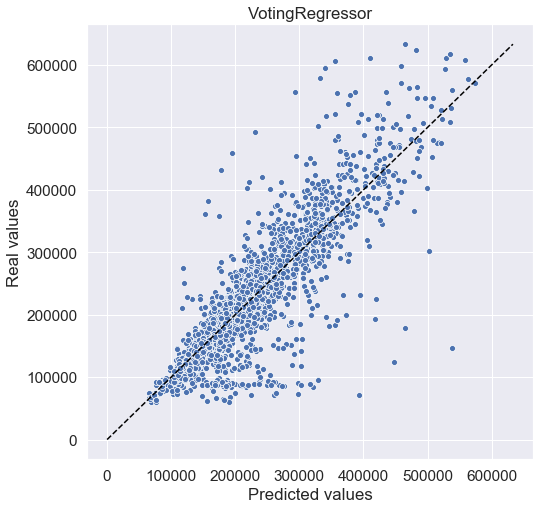

In [70]:
model_test(model, 'VotingRegressor', X_test, y_test)

In [72]:
model.fit(train[features], train[target])

VotingRegressor(estimators=[('model1',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                

## Конечный результат

In [73]:
test = pd.read_csv('Dataset/test.csv')

In [74]:
test = data_prepare(test)

Memory usage of dataframe is 0.79 MB
Memory usage after optimization is: 0.27 MB
Decreased by 65.7%


In [75]:
test_features = features

In [76]:
feature_names_for_stand = test[test_features].columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'cluster_year',
 'mean_price_dr',
 'mean_price_by_rooms',
 'large_district',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [77]:
stand_features = scaler.transform(test[feature_names_for_stand])
test[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [78]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           5000 non-null   float32
 1   Rooms                5000 non-null   float32
 2   Square               5000 non-null   float32
 3   LifeSquare           5000 non-null   float32
 4   KitchenSquare        5000 non-null   float32
 5   Floor                5000 non-null   float32
 6   HouseFloor           5000 non-null   float32
 7   HouseYear            5000 non-null   float32
 8   Ecology_1            5000 non-null   float32
 9   Social_1             5000 non-null   float32
 10  Social_2             5000 non-null   float32
 11  Social_3             5000 non-null   float32
 12  Helthcare_2          5000 non-null   float32
 13  Shops_1              5000 non-null   float32
 14  cluster_year         5000 non-null   float32
 15  mean_price_dr        5000 non-null   f

In [79]:
test['Price'] = model.predict(test[test_features])

Text(0.5, 1.0, 'Price distribution')

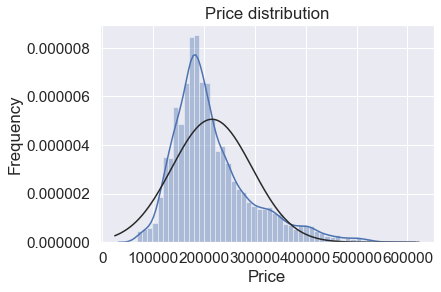

In [80]:
sns.distplot(test['Price'], fit=norm)


plt.ylabel('Frequency')
plt.title('Price distribution')

In [229]:
test[['Id', 'Price']].to_csv('predictions.csv', index=None)